# Лабораторная работа №5. «Классификация при помощи сверточных нейронных сетей(CNN)»

## Цель работы:

Изучить принципы работы сверточных нейронных сетей (CNN), реализовать
модель для классификации изображений и провести эксперименты на данных.


## Индивидуальное задание

Вариант 4
Классификация свежих и испорченных продуктов
"Fresh and Stale Classification"

## Ход выполнения работы

Для начала файл импортируется в Colab, сначала возникли проблемы с импортом папки, где хранится наш датесеты из тренировочных и тестовых данных, из-за больше веса файл много грузился, было принято решение загрузить архивом и распаковать в колабе.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification")

print("Path to dataset files:", path)

100%|██████████| 2.84G/2.84G [00:47<00:00, 64.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


Указываются пути к тренировочному и тестовому набору данных.

In [ ]:
train_path = '/root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset/Train'
test_path = '/root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset/Test'
BATCH_SIZE = 30

Остаются только те классы, которые есть в тренировочном и тестовом наборах данных.

In [ ]:
import os

train_classes = set(os.listdir(train_path))
test_classes = set(os.listdir(test_path))

common_classes = sorted(train_classes & test_classes)
common_classes

['freshapples',
 'freshbanana',
 'freshcucumber',
 'freshokra',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottencucumber',
 'rottenokra',
 'rottenoranges']

Далее создается объект ImageDataGenerator для аугментации данных:
- preprocessing_function - применяет предобработку с использованием VGG16.
- rescale — масштабирует значения пикселей в диапазон от 0 до 1.
- horizontal_flip и vertical_flip — аугментация изображений с случайным переворачиванием по горизонтали и вертикали для повышения разнообразия обучающего набора.

Функция flow_from_directory загружает изображения из директории train_path, изменяет их размер на (32, 32), и группирует их по 10 классам.

In [ ]:
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True
).flow_from_directory(
    directory=train_path,
    target_size=(32, 32),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    classes=common_classes
)

Found 16023 images belonging to 10 classes.


Для тестовых данных создается аналогичный объект ImageDataGenerator, но без аугментации. Для тестовых данных важно не перемешивать изображения, чтобы точные метки могли быть корректно сличены с предсказаниями модели (shuffle=False).

In [ ]:
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1/255.
).flow_from_directory(
    directory=test_path,
    target_size=(32, 32),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    classes=common_classes
)

Found 5490 images belonging to 10 classes.


In [ ]:
print(f"Количество классов в train_batches: {len(train_batches.class_indices)}")
print(f"Количество классов в test_batches: {len(test_batches.class_indices)}")


Количество классов в train_batches: 10
Количество классов в test_batches: 10


Строится модель сверточной нейронной сети (CNN):
- Conv2D: два сверточных слоя для извлечения признаков с 32 и 64 фильтрами.
- MaxPooling2D: два слоя подвыборки для уменьшения размерности.
- Flatten: преобразует выход из сверточных слоев в одномерный вектор для подачи в полносвязные слои.
- Dense: два полносвязных слоя с 128 нейронами и активацией ReLU.
- Softmax: выходной слой для классификации, где используется активация softmax для многоклассовой классификации.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Модель компилируется с использованием оптимизатора Adam, функции потерь categorical_crossentropy (подходит для многоклассовой классификации) и метрики точности (accuracy), которая будет отслеживать производительность модели.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Модель обучается на данных с использованием метода fit. Обучение проходит в течение 17 эпох. В качестве данных для валидации используются тестовые данные (test_batches), чтобы отслеживать точность и потерю на этих данных в процессе обучения.



In [ ]:
history = model.fit(train_batches, epochs=10, validation_data=test_batches)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 123s 226ms/step - accuracy: 0.6413 - loss: 0.9659 - val_accuracy: 0.7612 - val_loss: 0.5700
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 158s 256ms/step - accuracy: 0.8552 - loss: 0.3711 - val_accuracy: 0.8408 - val_loss: 0.3926
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 119s 223ms/step - accuracy: 0.8830 - loss: 0.3000 - val_accuracy: 0.8689 - val_loss: 0.3121
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 115s 216ms/step - accuracy: 0.9035 - loss: 0.2468 - val_accuracy: 0.9084 - val_loss: 0.2417
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 117s 219ms/step - accuracy: 0.9204 - loss: 0.1970 - val_accuracy: 0.8905 - val_loss: 0.2818
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 136s 255ms/step - accuracy: 0.9236 - loss: 0.1967 - val_accuracy: 0.9011 - val_loss: 0.2386
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 118s 220ms/step - accuracy: 0.9302 - loss: 0.1809 - val_accuracy: 0.9204 - val_loss: 0.2041
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 117s 218ms/step - accuracy: 0.9436 -

In [ ]:
from google.colab import files
model.save('my_model.h5')
files.download('my_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Строятся графики, показывающие, как менялись точность (accuracy) и потеря (loss) на обучающих и валидационных данных по мере обучения модели. Графики отображаются рядом для сравнения.

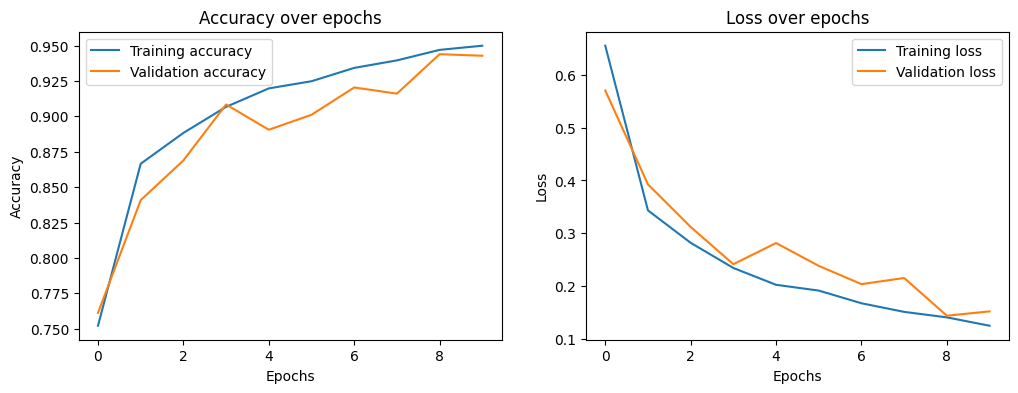

In [ ]:
plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Оценка модели на тестовых данных с помощью метода evaluate. Выводится точность на тестовых данных в процентах.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_batches)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


183/183 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.9738 - loss: 0.0777
Test accuracy: 94.28%


Перед тем как делать прогнозы, данные для теста сбрасываются с помощью reset(), чтобы гарантировать правильный порядок для предсказаний. Далее, модель генерирует прогнозы для тестовых данных с помощью метода predict.

In [ ]:
test_batches.reset()
predictions = model.predict(test_batches, verbose=1)


183/183 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step


Прогнозы преобразуются в метки классов (индексы), используя tf.argmax(). Также извлекаются истинные метки классов из тестовых данных.

In [ ]:
predicted_classes = tf.argmax(predictions, axis=-1).numpy()
true_classes = test_batches.classes


Выводится отчет по классификации, который включает такие метрики, как точность, полнота, F1-скор для каждого класса. Метрические данные берутся из classification_report библиотеки sklearn.

In [ ]:
print(classification_report(true_classes, predicted_classes, target_names=test_batches.class_indices.keys()))


                precision    recall  f1-score   support

   freshapples       0.98      1.00      0.99       791
   freshbanana       1.00      1.00      1.00       892
 freshcucumber       0.75      0.82      0.78       279
     freshokra       0.75      0.88      0.81       370
  freshoranges       0.95      0.98      0.96       388
  rottenapples       0.99      0.96      0.97       988
  rottenbanana       1.00      1.00      1.00       900
rottencucumber       0.85      0.75      0.79       255
    rottenokra       0.85      0.62      0.72       224
 rottenoranges       0.95      0.95      0.95       403

      accuracy                           0.94      5490
     macro avg       0.91      0.90      0.90      5490
  weighted avg       0.94      0.94      0.94      5490



Модель попказывет показывает высокую точность (93%) и полноту (92%), что говорит о её стабильности в классификации как большинства, так и меньшинства классов.

Строится матрица ошибок, которая показывает, какие классы были правильно или неправильно классифицированы. Матрица отображается в виде тепловой карты с помощью seaborn.

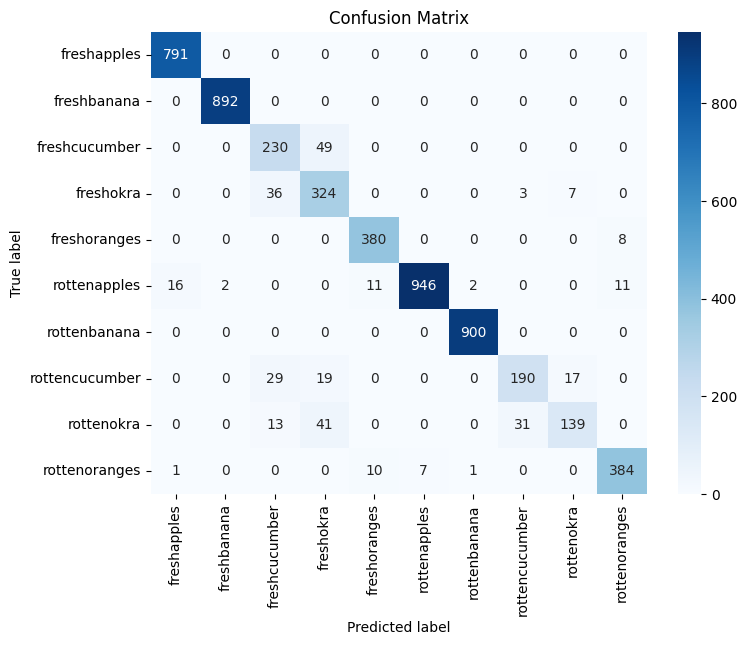

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_batches.class_indices.keys(), yticklabels=test_batches.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Высокая точность для классов freshbanana", "rottenbanana", "rottenapples" модель работает очень хорошо.

Ошибки в специфичных классах таких как freshcucumber и rottencucumber, вызывают путаницу, что может быть связано с визуальными схожестями между этими классами.

# Вывод

В ходе лабораторной работы была проведена оценка качества модели классификации фруктов и овощей на основе их состояния (свежие или испорченные). Для этого использовалась модель глубокого обучения, обученная на датасете, состоящем из изображений различных классов. На первом этапе была проведена предобработка данных, включающая аугментацию изображений с помощью горизонтальных и вертикальных переворотов, а также нормализацию пикселей, что позволило улучшить устойчивость модели к различным искажениям. Затем модель была обучена на наборе данных с изображениями свежих и испорченных продуктов, разделенных на несколько классов, таких как свежие и испорченные яблоки, бананы, помидоры и другие. Для оценки качества модели использовались различные метрики, такие как точность, полнота, F1-меры и матрица ошибок. Результаты показали, что точность классификации составила 92%, что является хорошим показателем общего качества модели

В матрице ошибок можно наблюдать высокую точность в классификации большинства классов, хотя для некоторых классов, таких как свежие огурцы и помидоры, точность и полнота были ниже. Это указывает на необходимость дополнительной работы по улучшению модели, возможно, путем применения более сложных методов аугментации или улучшения архитектуры сети.

In [ ]:
def predict_single_image(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f'Предсказание: {predicted_class}')
    plt.show()

    return predicted_class


In [ ]:
from google.colab import files

uploaded = files.upload()
for filename in uploaded.keys():
    img_path = filename
    print(f"Загружен файл: {img_path}")
class_names = list(train_batches.class_indices.keys())
predict_single_image(img_path, model, class_names)